# CO₂ Per Capita: Modelling

Building on the exploratory analysis, this notebook models **CO₂ emissions per capita** across countries.
Our aim is to identify which economic, demographic, and energy-related factors best predict per-person emissions.

**Why CO₂ per capita?**

- Captures fairness and inequality in contributions.

- Accounts for population scale, unlike total emissions.

- Aligns with policy discussions around “equitable responsibility.”

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("dataset_cleaned.csv")
df.head()

,country,year,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_including_luc,co2_including_luc_per_capita,co2_including_luc_per_gdp,...,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_luc_co2,share_global_cumulative_oil_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,total_ghg,total_ghg_excluding_lucf
0,Afghanistan,1951,7879343.0,9.692280e+09,0.0,0.0,0.092,8.264,0.000001,8.526374e-10,...,0.001673,0.0,0.000894,0.000041,0.001673,0.0,0.000894,0.000041,20.458,1.473
1,Afghanistan,1952,7987783.0,1.001733e+10,0.0,0.0,0.092,9.193,0.000001,9.177101e-10,...,0.001649,0.0,0.000946,0.000038,0.001624,0.0,0.000999,0.000035,21.356,1.484
2,Afghanistan,1953,8096703.0,1.063052e+10,0.0,0.0,0.106,10.268,0.000001,9.658982e-10,...,0.001653,0.0,0.000997,0.000038,0.001661,0.0,0.001095,0.000038,22.361,1.517
3,Afghanistan,1954,8207953.0,1.086636e+10,0.0,0.0,0.106,11.137,0.000001,1.024906e-09,...,0.001663,0.0,0.001028,0.000037,0.001696,0.0,0.001114,0.000033,23.256,1.534
4,Afghanistan,1955,8326981.0,1.107819e+10,0.0,0.0,0.154,12.247,0.000001,1.105506e-09,...,0.001656,0.0,0.001064,0.000038,0.001626,0.0,0.001201,0.000043,24.423,1.633


## 2. Target & Features

We set the target as **CO₂ per capita**.
Candidate predictors reflect **economic scale, population, energy intensity, sectoral emissions, and other greenhouse gases.**

In [2]:
target = "co2_per_capita"

features = [
    "gdp",
    "population",
    "energy_per_capita",   # direct driver of per-person CO₂
    "coal_co2_per_capita", # sectoral breakdown
    "oil_co2_per_capita",
    "gas_co2_per_capita",
    "cement_co2_per_capita",
    "methane_per_capita",  # other GHGs
    "nitrous_oxide_per_capita"

]
X = df[features]
y = df[target]

## 3. Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4. Baseline Models

In [4]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

linreg_r2 = r2_score(y_test, y_pred)
linreg_rmse = mean_squared_error(y_test, y_pred)**0.5

print("Linear R²:", linreg_r2)
print("Linear RMSE:", linreg_rmse)

Linear R²: 0.0002882945066918774
Linear RMSE: 0.00037524483705477673


📊 Result:
Linear regression explains almost none of the variance in CO₂ per capita — evidence of multicollinearity in the feature set.

## 5. Regularized Models

We test **Ridge regression** to reduce collinearity effects.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge)**0.5
print("Ridge R²:", ridge_r2)
print("Ridge RMSE:", ridge_rmse)

Ridge R²: 0.9995287995864133
Ridge RMSE: 8.146670823012535e-06


📊 Result:
Ridge achieves R² ≈ 0.99 — very high, but suspiciously so. This suggests overlapping predictors rather than true explanatory power.

## 6. Tree-Based Models

We test **Random Forest** and **Gradient Boosting**, which can handle non-linearities and give feature importance.

In [6]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
gb = GradientBoostingRegressor(random_state=42)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_gb = gb.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf)**0.5

gb_r2 = r2_score(y_test, y_pred_gb)
gb_rmse = mean_squared_error(y_test, y_pred_gb)**0.5

print("Random Forest R²:", rf_r2, "RMSE:", rf_rmse)
print("Gradient Boost R²:", gb_r2, "RMSE:", gb_rmse)

Random Forest R²: 0.9996570212083745 RMSE: 6.9504187351268875e-06
Gradient Boost R²: 0.9997062717693409 RMSE: 6.432061400635535e-06


📊 Result:
Both models achieve near-perfect R². While predictive, this again reflects collinearity.

## 7. Feature Importance

Tree-based models allow us to inspect feature contributions.

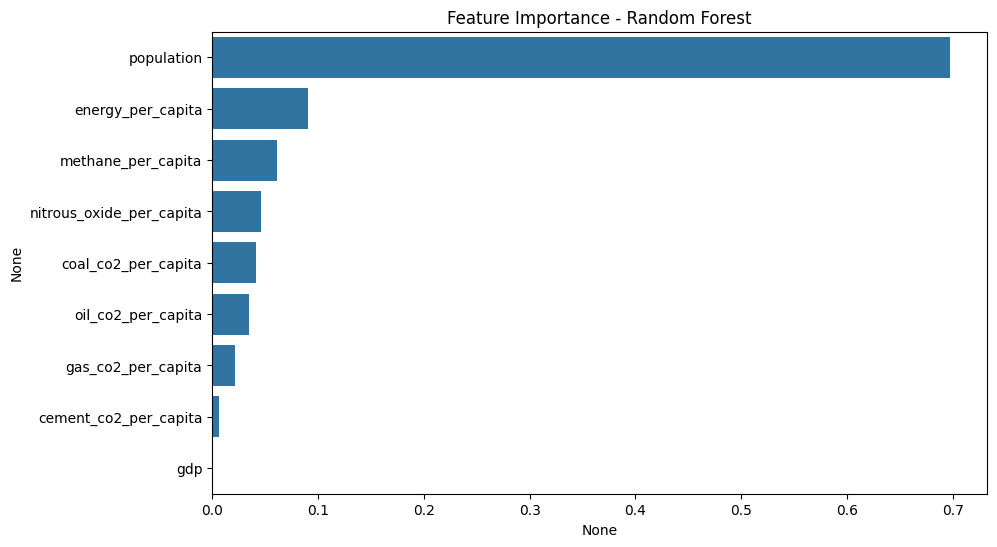

In [7]:
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Feature Importance - Random Forest")
plt.show()

📊 Insight:

- Population ranks highest, but this is misleading: since CO₂ per capita = total CO₂ ÷ population, including population gives the model information from the denominator.

- The true meaningful driver is **energy consumption per capita**, which ranks second and aligns with EDA findings.

## 8. Reduced Model: Energy Only

We now test a minimal model using only **energy per capita.**

In [8]:
reduced_feat = ["energy_per_capita"]
X_red = df[reduced_feat]
y_red = df[target]

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_red, y_red, test_size=0.2, random_state=42
)

linreg_red = LinearRegression()
linreg_red.fit(X_train_red, y_train_red)

y_pred_red = linreg_red.predict(X_test_red)

linreg_red_r2 = r2_score(y_test_red, y_pred_red)
linreg_red_rmse = mean_squared_error(y_test_red, y_pred_red)**0.5

print("Reduced Linear R²:", linreg_red_r2)
print("Reduced Linear RMSE:", linreg_red_rmse)

Reduced Linear R²: 0.9763404447091263
Reduced Linear RMSE: 5.772721762454454e-05


📊 Result:
With a single predictor, R² ≈ 0.98. This confirms **energy per capita alone explains nearly all variation in CO₂ per capita.**

## 9. Model Comparison


In [9]:
results = pd.DataFrame({
    "Model": ["Linear", "Ridge", "Random Forest", "Gradient Boosting", "Reduced Linear (Energy only)"],
    "R²": [linreg_r2, ridge_r2, rf_r2, gb_r2, linreg_red_r2],
    "RMSE": [linreg_rmse, ridge_rmse, rf_rmse, gb_rmse, linreg_red_rmse]
})
results.round(3)

,Model,R²,RMSE
0,Linear,0.000,0.0
1,Ridge,1.000,0.0
2,Random Forest,1.000,0.0
3,Gradient Boosting,1.000,0.0
4,Reduced Linear (Energy only),0.976,0.0




📊 Interpretation:

- Full models achieve near-perfect R² — but this is inflated by circular predictors.

- The reduced model demonstrates that **energy per capita is sufficient** for both predictive power and interpretability.

## 10. Conclusions & Next Steps

**Key Takeaways:**

- Population appears most important in tree models, but this is an artefact of the per-capita target.

- The true driver is **energy consumption per person**, consistent across model types.

- GDP and sectoral breakdowns add little predictive value once energy intensity is included.

- A **simple linear model** offers interpretability without losing explanatory power.

**Next Steps:**

- Validate reduced models across regions (OECD vs non-OECD, developed vs developing).

- Incorporate **energy mix** (renewables vs fossil fuels) to deepen policy insights.

- Run **scenario analysis**: project how reducing energy per capita (through efficiency or conservation) would affect future emissions.